## Car Accident Severity

### Introduction/Business Problem

Every year there are approximately 6 million car accidents in the US alone.  Car accidents are cause of the thousands of deaths and billions of dollars in expenses according to the US Car Accident statistics.
Analyzing the accident data in a major city like Seattle, may offer insights on car accidents in other major cities as well.
Goal is to understand this data to predict what factors lead to severity of accidents such as location, weather conditions, collision type etc.  Are there any factors we can educate the public to reduce the number of accidents.  Also, if find strong co-relation with certain weather conditions and severity of accidents, it may help to warn the drivers when faced with sthis situations.  This information can also be used to decide policies e.g. speed limit, closure of roads due to certain conditions etc.  Car insurance companies will also be interested to learn the insights from this data.  


### Data

Dataset is Seattle city collision data provided by the Seattle Police Department and recorded by Traffic Records.  It consists  ~194673 instances of collisions and ~38 attributes describing the event - severity of the accident, location, weather, collision type etc.  Collisions will be displayed at the intersection or mid-block of a segment. Timeframe of the data is 2004 to Present, thus it includes over 15 years of data that will help to see the trend over a decade.

This data will be explored to find what features most relevant to predict the severity of the accident.
 
Meta data to understand the attributes: https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf

For example: SEVERITYCODE: A code that corresponds to the severity of the collision.

    3—fatality
    2b—serious injury
    2—injury
    1—prop damage
    0—unknown 
    
For purpose of this analysis when SEVERITYCODE is 2, that's severe collision and when it's 1, it's not as severe.  Goal is to predict based on the given features.



#### Data Cleaning

Dataset has 194673 rows and 38 columns. However, not all columns are relevant.  So first created subset using only relevant columns:

    SEVERITYCODE, ADDRTYPE, COLLISIONTYPE, PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, JUNCTIONTYPE, INATTENTIONIND, WEATHER, 
    ROADCOND, LIGHTCOND, UNDERINFL,SPEEDING,HITPARKEDCAR.
    
Some of the cleaning steps were: 

    (1) Remove rows when Junctiontype, Weather, Reoad Condition or Light Condition is 'Unknown'.
    
    (2) INATTENTIONIND, SPEEDING while driving when Not available, set to 'No' as that seems logical option.
    
    (3) INATTENTIONIND, SPEEDING, HITPARKEDCAR, UNDERINFL had mixed values Y, N, 1, 0.  
        'Y' was converted to 1 and 'N' to 0.
    
    (4) Remove rows with NaN for ADDRTYPE, COLLISIONTYPE, WEATHER, LIGHTCOND, ROADCOND.  
        Also while convering categorical values to numeric if column containts 'Other' it was removed.
    
Removing this does introduce bias in data sampling, but there is no way around that problem in the scope of this assignment.

#### Data Exploration (qualitative)

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

filename = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(filename)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df.shape

(194673, 38)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

<AxesSubplot:>

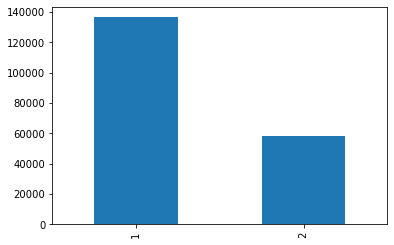

In [7]:
# 1: prop damage and 2: injury.
df['SEVERITYCODE'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

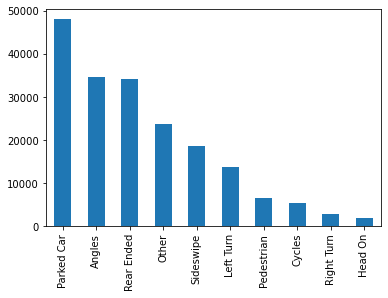

In [6]:
# Surprisingly Parked Car tops number of collisions.
df['COLLISIONTYPE'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

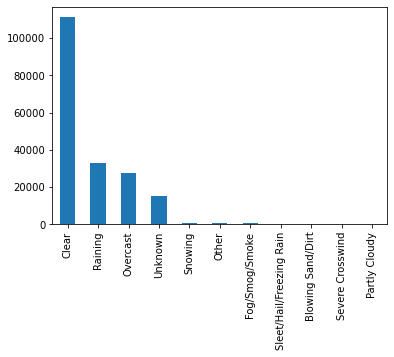

In [8]:
# Data indicates most collisions happen in Clear weather followed by Raining, Overcast.
df['WEATHER'].value_counts().plot(kind='bar')

<AxesSubplot:>

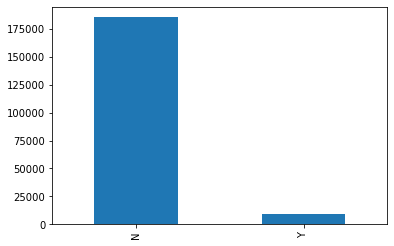

In [9]:
# Replaced NaN for SPEEDING WITH 'N', data indicates most accidents happen when not speeding
df['SPEEDING'] = df['SPEEDING'].fillna('N')
df['SPEEDING'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

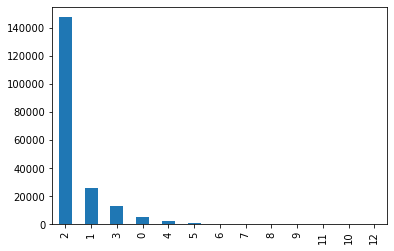

In [10]:
# Data indicates most collisions involce 2, 1 or 3 vehicles.
df['VEHCOUNT'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

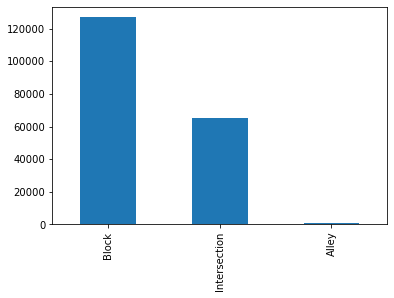

In [11]:
# Majority of collisions in Block side vs. Alley.
df['ADDRTYPE'].value_counts().plot(kind = 'bar')